In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau
from scipy import ndimage

from glob import glob
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries
from scipy import spatial

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
fn_membrane = '/Users/prakash/Desktop/Bob_Segmentation/similar/membrane.tif'
fn_myosin   = '/Users/prakash/Desktop/Bob_Segmentation/similar/myosin.tif'

segchannel = imread(fn_membrane)
flowchannel = imread(fn_myosin)

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

gradientimage = segchannel_smooth
# gradientimage = np.minimum(flowchannel_smooth/np.mean(flowchannel_smooth), np.ones_like(flowchannel_smooth))
# gradientimage += segchannel_smooth/np.max(segchannel_smooth)
# gx = np.gradient(gradientimage, 25, axis=2)
# gy = np.gradient(gradientimage, 25, axis=1)
# gx = np.abs(gx)
# gy = np.abs(gy)
# gradientimage = gx+gy                  # add x and y gradients
# gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
# gradientimage **= .5                   # emphasizes smaller gradient values
# gradientimage = gaussian(gradientimage,sigma)

T = len(segchannel)-1  # number of time-points (last one is superfluous)
tempres_factor = int(len(flowchannel)/T)
print(tempres_factor)

# if len(flowchannel)%T != 0:
#     raise 'Tempres problem: please check imported data!'
# else:
#     print ('Tempres factor: %s'%tempres_factor)

print('Shape of membrane channel :', segchannel.shape)
print('Shape of flow channel:', flowchannel.shape)

6
Shape of membrane channel : (11, 580, 875)
Shape of flow channel: (60, 580, 875)


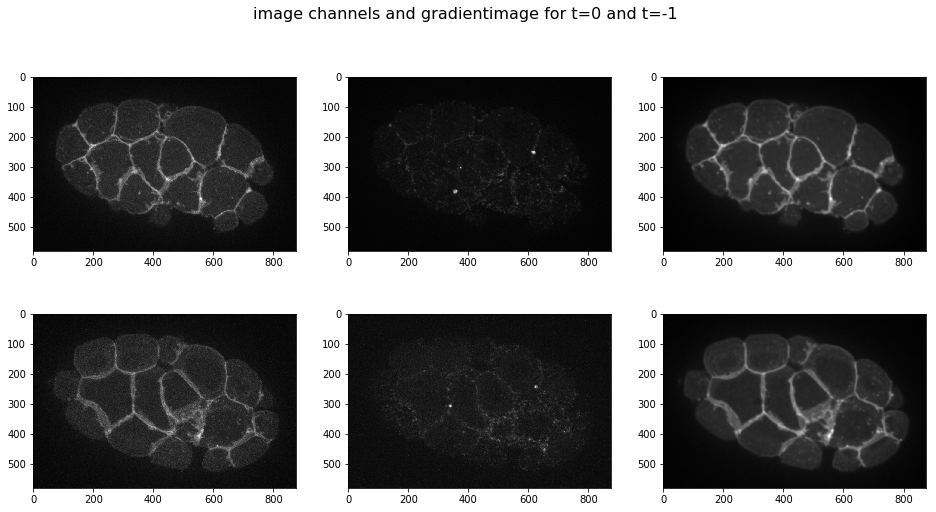

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
# fig.tight_layout()

# Cell segmentation

In [4]:
curated = imread('/Users/prakash/Desktop/Bob_Segmentation/similar/seg.tif') # expects only connected components
#TODO: Add a hole filling step
labels = []
for i in range(0,curated.shape[0]):
    labels_per_frame, _ = ndimage.label(curated[i])
#     plt.imshow(labels_per_frame)
    label_size = []
    label_ids = []
    regions = regionprops(labels_per_frame)
    for props in regions:
        label_ids.append(props.label)
        label_size.append(props.area)
        for label_number in range(0, len(label_ids)): # Filtering out components smaller than 1000 area
            if label_size[label_number] < 1000 :
                labels_per_frame[ labels_per_frame == label_ids[label_number] ] = 0
    labels.append(labels_per_frame)
#     plt.imshow(labels_per_frame)
#     plt.show()
#     imsave('/Users/prakash/Desktop/Bob_Segmentation/similar/test_label'+str(i)+'.tif', labels_per_frame)

In [5]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=True )
data.set_segProcessing_params(num_columns=72,K=70)
objects = []
seeds = []

In [6]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
Ea_centroid_this_frame = (400, 500) # x, y reversed for kdtree
seeds.append(Ea_centroid_this_frame)

In [7]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
Ep_centroid_this_frame = (350, 600) # x, y reversed for kdtree
seeds.append(Ep_centroid_this_frame)

In [8]:
unsampled_surface_coords = {}
query_centroids = {}

for obj in range(len(objects)):
    
    object_centroids = []
    unsampled_surface_coords_per_object = []
    
    for frame in range(0, curated.shape[0]):

        all_centroids_per_frame = []
        label_per_frame = []
        regions = regionprops(labels[frame])
        for props in regions:
            all_centroids_per_frame.append(props.centroid)
            label_per_frame.append(props.label)
        distance,index = spatial.KDTree(all_centroids_per_frame).query(seeds[obj])
    #     print('Corresponding Ea label is:',label_per_frame[index_Ea])
        label_boundaries_per_frame = find_boundaries(labels[frame] == label_per_frame[index])
        surface_coord_per_frame = np.column_stack(np.where(label_boundaries_per_frame))
        surface_coord_per_frame = surface_coord_per_frame.tolist()
        surface_coord_per_frame = [tuple(l) for l in surface_coord_per_frame]

        unsampled_surface_coords_per_object.append(surface_coord_per_frame)

        object_centroid_this_frame = all_centroids_per_frame[index]
        
        object_centroids.append(object_centroid_this_frame)
    
    
    unsampled_surface_coords[obj] = unsampled_surface_coords_per_object
    query_centroids[obj] = object_centroids

In [9]:
def sample_circle( n=18 ):
    '''
        Returns n many points on the unit circle (equally spaced).
    '''
    points = np.zeros([n,2])
    for i in range(n):
        angle = 2*math.pi * i/float(n)
        x = math.cos(angle)
        y = math.sin(angle)
        # print angle, x, y
        points[i] = [x,y]
        
    return points

In [10]:
num_columns = 74
K = 70
col_vectors = sample_circle( num_columns )
min_radius = (5,5)
max_radius = (100,100)

In [11]:
def get_coords(obj_id):
    
    '''
        Returns coordinates of points on the columns for the queried object
    '''
    sampled_surface_coords = {}
    for t in range(curated.shape[0]):
        surface_coords_per_time = []
        print('t:', t)
        for i in range(num_columns):
            from_x = int(query_centroids[obj_id][t][0] + col_vectors[i,0]*min_radius[0])
            from_y = int(query_centroids[obj_id][t][1] + col_vectors[i,1]*min_radius[1])
            to_x = int(query_centroids[obj_id][t][0] + col_vectors[i,0]*max_radius[0])
            to_y = int(query_centroids[obj_id][t][1] + col_vectors[i,1]*max_radius[1])
            coords_per_column = bham.bresenhamline(np.array([[from_x, from_y]]), np.array([[to_x, to_y]]))
            num_pixels = len(coords_per_column)
            coords_per_column = coords_per_column.tolist()
            coords_per_column = [tuple(l) for l in coords_per_column]
#             surface_coords_per_column = find_surface_coords_on_bresenham(coords_per_column)
            surface_coords_per_column = [i for i in coords_per_column if i in unsampled_surface_coords[obj_id][t]]
            print('i:', i)
            print(surface_coords_per_column)
            if(surface_coords_per_column != []):
                surface_coords_per_column = surface_coords_per_column[0] #Only keep first element/match
                surface_coords_per_time.append(surface_coords_per_column)
            
        sampled_surface_coords[t] = surface_coords_per_time
        
    return sampled_surface_coords

In [12]:
# def find_surface_coords_on_bresenham(coords_per_col):
    

In [13]:
sampled_coords = {} #key: object_id, 
# value: dictionary with key: time, value: list of lists (coordinate matches along column with segmentation)
#Inner list is matches along each column id 

for ob in range(len(objects)):
    sampled_coords[ob] = get_coords(ob)

t: 0
i: 0
[(443, 502), (444, 502)]
i: 1
[(445, 507), (446, 508)]
i: 2
[(447, 513), (448, 513)]
i: 3
[(448, 519), (449, 519)]
i: 4
[(444, 524), (445, 524), (446, 524)]
i: 5
[(441, 528), (442, 529)]
i: 6
[(442, 535), (443, 536)]
i: 7
[(443, 543)]
i: 8
[(439, 547)]
i: 9
[(431, 548)]
i: 10
[(423, 548), (424, 549)]
i: 11
[(417, 548), (418, 549)]
i: 12
[(411, 548), (412, 549)]
i: 13
[(406, 548)]
i: 14
[(401, 548), (402, 549)]
i: 15
[(396, 546), (396, 547), (397, 548)]
i: 16
[(392, 545), (392, 546)]
i: 17
[(386, 530), (386, 531), (386, 532), (386, 533), (386, 534), (387, 535), (387, 537), (387, 538), (387, 539), (387, 540), (387, 541), (387, 542), (388, 543), (388, 544)]
i: 18
[(384, 528), (384, 529)]
i: 19
[(382, 529), (382, 530)]
i: 20
[(379, 534), (378, 537), (378, 538), (378, 539), (378, 540), (378, 541), (378, 542), (377, 543), (377, 544)]
i: 21
[(374, 546), (373, 547), (373, 548)]
i: 22
[(369, 545), (369, 546)]
i: 23
[(366, 543)]
i: 24
[(363, 541), (362, 542), (362, 543)]
i: 25
[(358, 5

i: 69
[(428, 466), (429, 466)]
i: 70
[(431, 469)]
i: 71
[(433, 473)]
i: 72
[(413, 481), (436, 477)]
i: 73
[(412, 482), (413, 482), (414, 482), (415, 482), (416, 482), (417, 482), (437, 480), (438, 480)]
t: 3
i: 0
[(432, 486), (433, 486)]
i: 1
[(435, 491), (436, 491)]
i: 2
[(436, 494), (437, 495)]
i: 3
[(437, 500), (438, 500)]
i: 4
[(438, 505), (439, 505)]
i: 5
[(438, 510), (439, 510)]
i: 6
[(413, 501), (433, 512), (434, 512), (435, 513), (436, 513)]
i: 7
[(409, 501), (410, 502), (411, 502), (415, 505), (416, 506), (427, 513)]
i: 8
[(406, 502), (407, 503), (414, 508), (424, 516), (425, 517), (426, 518)]
i: 9
[(404, 503), (405, 504), (413, 511), (425, 523), (426, 524)]
i: 10
[(402, 503), (403, 504), (412, 514), (413, 515), (413, 516), (423, 527)]
i: 11
[(400, 504), (411, 518), (411, 519), (420, 530)]
i: 12
[(399, 505), (399, 506), (400, 508), (409, 521), (413, 529), (415, 531), (415, 532)]
i: 13
[(399, 510), (399, 511), (407, 526)]
i: 14
[(398, 513), (398, 514), (399, 515)]
i: 15
[(397, 

[(385, 522), (385, 523), (385, 524)]
i: 20
[(383, 520), (383, 521)]
i: 21
[(381, 517), (381, 518)]
i: 22
[(379, 516)]
i: 23
[(378, 514), (378, 515), (372, 530), (372, 531), (371, 533), (370, 534), (370, 535)]
i: 24
[(375, 514), (375, 515), (370, 524), (370, 525), (369, 527), (367, 531), (366, 532)]
i: 25
[(374, 514), (373, 515), (368, 523), (363, 531), (362, 532)]
i: 26
[(370, 514), (370, 515), (367, 519), (366, 520), (357, 532), (356, 533)]
i: 27
[(368, 514), (367, 515), (366, 516), (365, 517), (353, 531), (352, 532)]
i: 28
[(349, 529), (348, 529)]
i: 29
[(351, 521), (350, 522), (349, 523), (348, 524)]
i: 30
[(353, 516)]
i: 31
[(354, 511), (353, 511)]
i: 32
[(355, 507), (354, 508), (353, 508)]
i: 33
[(358, 503), (357, 504), (356, 504)]
i: 34
[(360, 500), (359, 500)]
i: 35
[(360, 498), (359, 498)]
i: 36
[(359, 495), (358, 495)]
i: 37
[(358, 493), (357, 493)]
i: 38
[(356, 490), (355, 490)]
i: 39
[(356, 488), (355, 488)]
i: 40
[(357, 485), (356, 485)]
i: 41
[(357, 482)]
i: 42
[(359, 481)

i: 54
[(384, 487), (384, 486), (383, 483), (383, 482), (383, 481), (383, 480), (383, 479), (383, 478)]
i: 55
[(385, 487), (385, 486)]
i: 56
[(388, 487), (388, 486)]
i: 57
[(389, 486), (389, 485), (390, 481)]
i: 58
[(392, 483), (393, 481), (393, 480)]
i: 59
[(395, 480), (395, 479), (396, 478)]
i: 60
[(400, 476), (400, 475), (401, 474)]
i: 61
[(403, 475), (404, 474)]
i: 62
[(406, 476), (407, 475)]
i: 63
[(408, 479)]
i: 64
[(410, 482), (410, 481)]
i: 65
[(411, 484), (412, 483)]
i: 66
[(411, 489), (412, 488)]
i: 67
[(412, 491), (413, 490)]
i: 68
[(413, 494), (414, 493)]
i: 69
[(417, 494), (418, 494)]
i: 70
[(419, 496)]
i: 71
[(419, 500), (420, 500)]
i: 72
[(419, 502), (420, 502)]
i: 73
[(419, 505), (420, 505)]
t: 0
i: 0
[(447, 630), (448, 630)]
i: 1
[(444, 635), (445, 635)]
i: 2
[(443, 641), (444, 641)]
i: 3
[(441, 646), (442, 646)]
i: 4
[(441, 651), (442, 652)]
i: 5
[(441, 658), (442, 658)]
i: 6
[(442, 665)]
i: 7
[(437, 669)]
i: 8
[(431, 672)]
i: 9
[(426, 674)]
i: 10
[(422, 678)]
i: 11
[(

i: 13
[(407, 689)]
i: 14
[(402, 689), (402, 690)]
i: 15
[(396, 689), (396, 690), (396, 691)]
i: 16
[(392, 703)]
i: 17
[(386, 706)]
i: 18
[(379, 711), (379, 712)]
i: 19
[(373, 711), (373, 712)]
i: 20
[(366, 710), (366, 711)]
i: 21
[(358, 708), (358, 709)]
i: 22
[(351, 708), (351, 709)]
i: 23
[(343, 710), (342, 711)]
i: 24
[(335, 709), (334, 710)]
i: 25
[(327, 707)]
i: 26
[(324, 697), (324, 698), (323, 699)]
i: 27
[(320, 690), (320, 691)]
i: 28
[(316, 685), (315, 685)]
i: 29
[(325, 667), (324, 668), (323, 669)]
i: 30
[(322, 663), (321, 663), (320, 664), (319, 665), (318, 665), (317, 666)]
i: 31
[(310, 663), (309, 664)]
i: 32
[(309, 657), (308, 658)]
i: 33
[(310, 650), (309, 650)]
i: 34
[(307, 645)]
i: 35
[(305, 638)]
i: 36
[(301, 633), (300, 633)]
i: 37
[(300, 626), (299, 626)]
i: 38
[(309, 621), (308, 621), (307, 621)]
i: 39
[(313, 616), (312, 616)]
i: 40
[(313, 610), (312, 610)]
i: 41
[(313, 604), (312, 604)]
i: 42
[(314, 598), (313, 598), (312, 597)]
i: 43
[(315, 592)]
i: 44
[(318, 58

[(322, 587)]
i: 48
[(328, 584), (327, 583)]
i: 49
[(334, 581)]
i: 50
[(339, 579), (339, 578)]
i: 51
[(346, 577), (345, 576)]
i: 52
[(352, 577), (352, 576)]
i: 53
[(358, 577)]
i: 54
[(364, 573), (363, 572)]
i: 55
[(369, 570), (369, 569)]
i: 56
[(376, 568), (376, 567)]
i: 57
[(382, 566), (382, 565)]
i: 58
[(389, 567), (389, 566)]
i: 59
[(396, 567), (396, 566), (397, 565)]
i: 60
[(405, 564), (405, 563), (406, 562)]
i: 61
[(412, 564)]
i: 62
[(418, 570)]
i: 63
[]
i: 64
[(438, 570)]
i: 65
[(443, 577)]
i: 66
[(446, 584)]
i: 67
[(447, 593), (448, 593)]
i: 68
[(448, 602), (449, 601), (450, 601)]
i: 69
[(443, 612)]
i: 70
[(446, 618), (447, 618)]
i: 71
[(447, 625), (448, 624)]
i: 72
[(446, 631), (447, 631)]
i: 73
[(447, 637), (448, 637)]
t: 9
i: 0
[(441, 642), (442, 642)]
i: 1
[(445, 648), (446, 648), (447, 648), (448, 648)]
i: 2
[(452, 657)]
i: 3
[(447, 663), (448, 663)]
i: 4
[(435, 666), (436, 666)]
i: 5
[(433, 672), (434, 672)]
i: 6
[(427, 676)]
i: 7
[(424, 681)]
i: 8
[(424, 688), (425, 689)]


In [14]:
sampled_coords # key: time, value: list of lists (coordinate matches along column with segmentation)
#Inner list is matches along each column id 

{0: {0: [(443, 502),
   (445, 507),
   (447, 513),
   (448, 519),
   (444, 524),
   (441, 528),
   (442, 535),
   (443, 543),
   (439, 547),
   (431, 548),
   (423, 548),
   (417, 548),
   (411, 548),
   (406, 548),
   (401, 548),
   (396, 546),
   (392, 545),
   (386, 530),
   (384, 528),
   (382, 529),
   (379, 534),
   (374, 546),
   (369, 545),
   (366, 543),
   (363, 541),
   (358, 542),
   (349, 547),
   (350, 539),
   (350, 534),
   (350, 529),
   (349, 525),
   (346, 522),
   (343, 520),
   (341, 517),
   (337, 514),
   (330, 511),
   (329, 507),
   (333, 502),
   (336, 498),
   (339, 494),
   (335, 490),
   (335, 485),
   (338, 482),
   (341, 479),
   (346, 477),
   (348, 474),
   (349, 470),
   (351, 466),
   (354, 463),
   (355, 457),
   (360, 458),
   (365, 457),
   (368, 455),
   (372, 451),
   (376, 452),
   (380, 449),
   (385, 439),
   (391, 436),
   (398, 432),
   (403, 434),
   (409, 436),
   (409, 451),
   (411, 456),
   (415, 458),
   (420, 460),
   (424, 463),
   (

In [15]:
def plot_result( obj, frame, ax, imagedata=None ):
    if imagedata is None:
        ax.imshow(images[frame], plt.get_cmap('gray'))
    else:
        ax.imshow(imagedata[frame], plt.get_cmap('gray'))

    for oid in range(len(objects)):
        patches = [] # collects patches to be plotted
        surface = sampled_coords[obj][frame]
        surface = [t[::-1] for t in surface]
        polygon = Polygon(surface, True)
        patches.append(polygon)
        a = 0.2 + (float(oid)/len(objects))*0.6
        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=a, color='green')
        ax.add_collection(p)

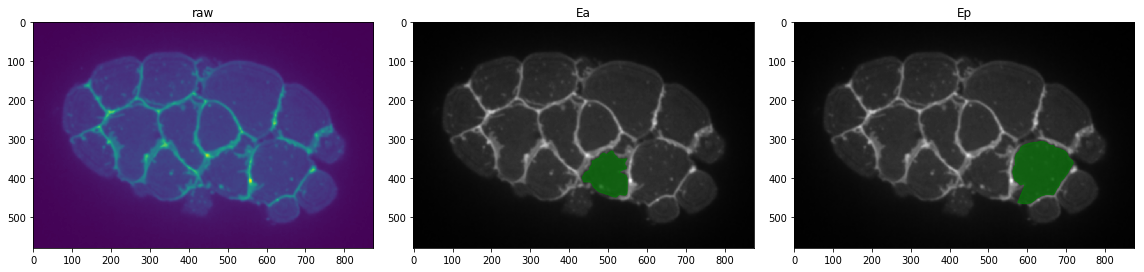

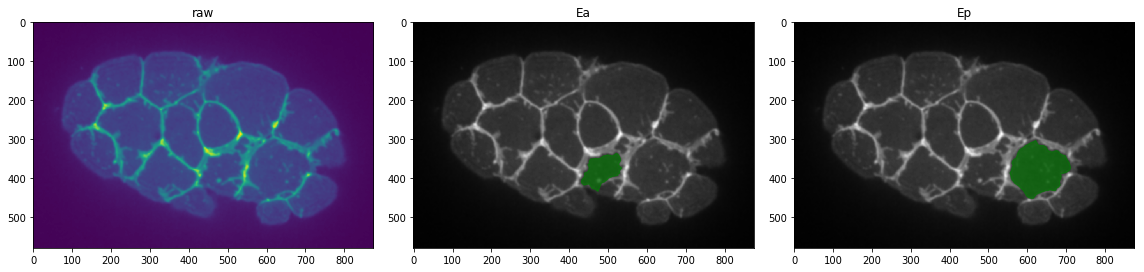

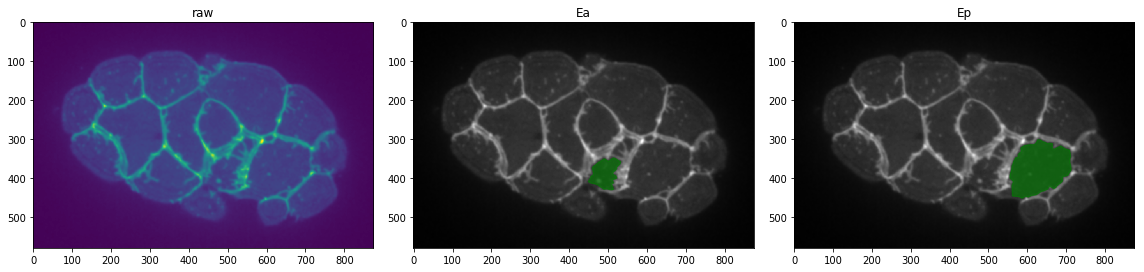

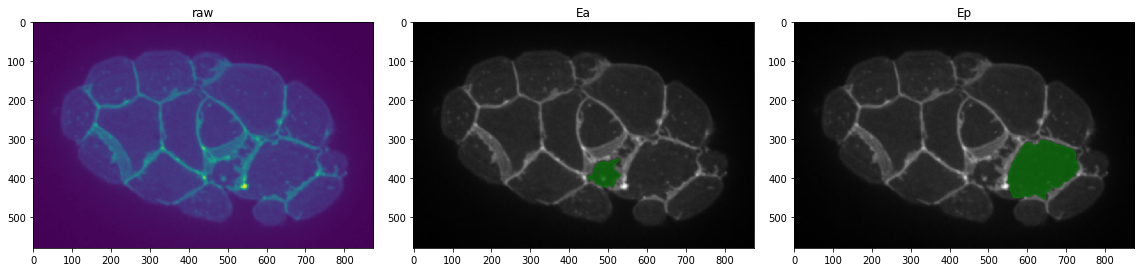

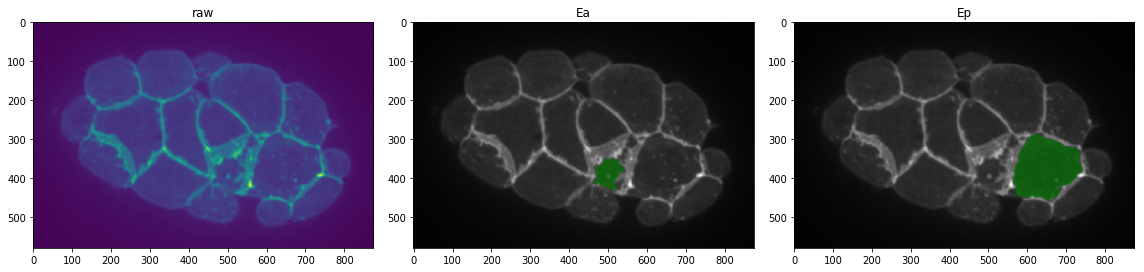

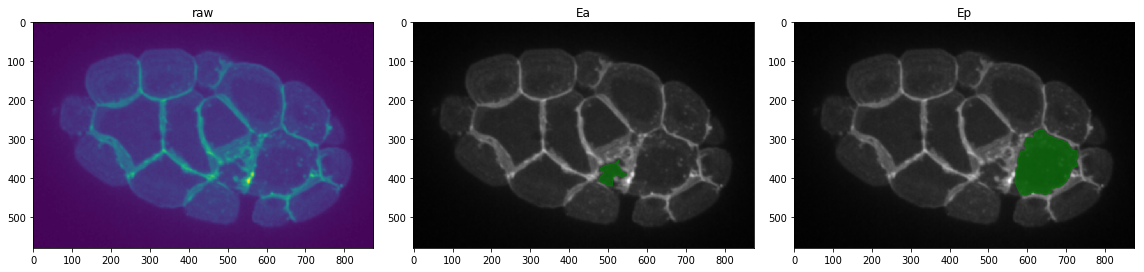

In [16]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(0,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    ax.set_title('raw')
    ax.imshow( segchannel_smooth[frame] )  
    ax = plt.subplot(132)
    ax.set_title('Ea')
    plot_result( 0, frame, ax, segchannel_smooth )  
    ax = plt.subplot(133)
    ax.set_title('Ep')
    plot_result( 1, frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation (taking higher frame-rate into account)

In [17]:
flows = imread('/Users/prakash/Desktop/Bob_Segmentation/similar/flow.tif')
print(flows.shape)

(120, 580, 875)


In [18]:
flow_x = []
flow_y = []
for i in range(0,flows.shape[0],2):
    singleflow_x = flows[i]
    singleflow_y = flows[i+1]
    flow_x.append(singleflow_x)
    flow_y.append(singleflow_y)

flow_x = np.array(flow_x)
flow_y = np.array(flow_y)

In [19]:
avg_flow_x = bsu.flow_merge_frames(flow_x, tempres_factor)
avg_flow_y = bsu.flow_merge_frames(flow_y, tempres_factor)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

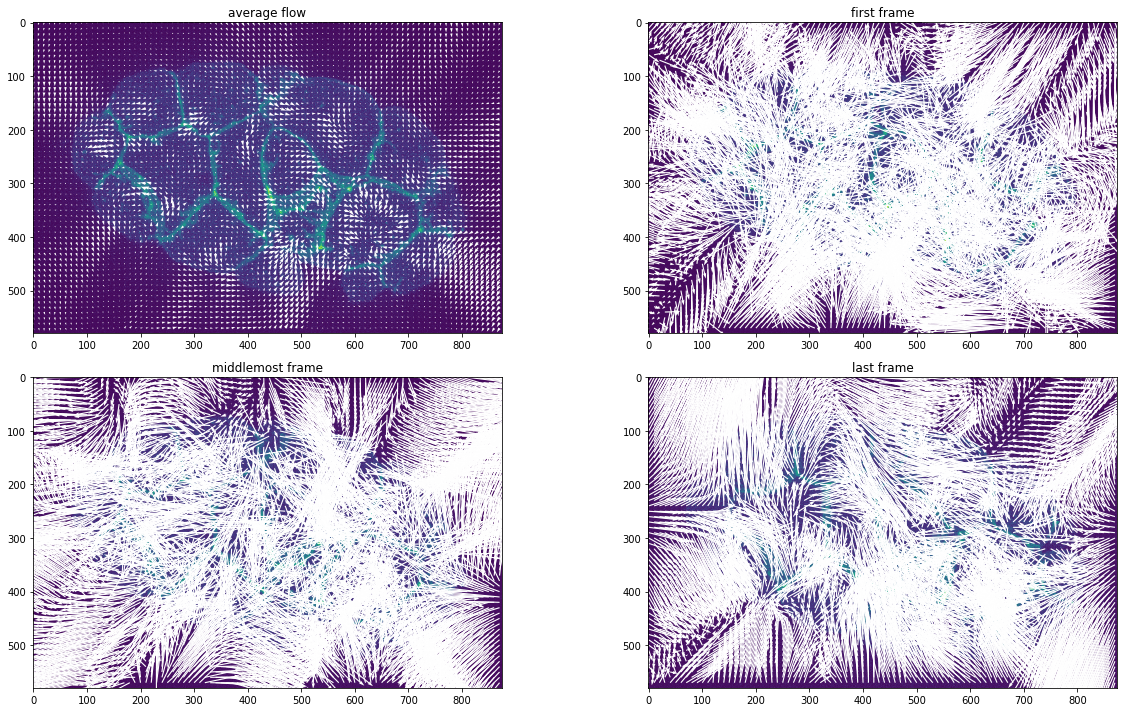

In [20]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale = 50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(segchannel)/2)][skip],-avg_flow_y[int(len(segchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [28]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [32]:
def shrink_polygone(coords, center, shrinkage_factor):
    
    ''' returns coordinates of shrunk polygone
        coords: list of tuples
        shrinkage_factor: between 0 and 1, cannot be 1; 0 being no shrinkage
    '''
    xs = [i[0] for i in coords]
    ys = [i[1] for i in coords]
    x_center = center[1]
    y_center = center[0]
    # shrink figure
    new_xs = [(i - x_center) * (1 - shrinkage_factor) + x_center for i in xs]
    new_ys = [(i - y_center) * (1 - shrinkage_factor) + y_center for i in ys]
    # create list of new coordinates
    new_coords = zip(new_xs, new_ys)
    new_coords = list(new_coords)
#     print(new_coords)
    return new_coords

In [33]:
def get_polygone_points( obj, frame, scaling_factor=1.0, calibration = (1.,1.) ):
    """
    scaling_factor: scales the polygone by the given factor, 1.0 by default. Center point stays constant.
    calibration: 2-tupel of pixel size multipliers
    """
    unscaled_surface_coords = sampled_coords[obj][frame]
    unscaled_surface_coords = [t[::-1] for t in unscaled_surface_coords]
    center = query_centroids[obj][frame]
    surface_coords = shrink_polygone(unscaled_surface_coords, center, scaling_factor)
    return surface_coords

In [24]:
# def get_surface_point( obj, frame, column_id, scaling_factor=1.0 ):
#     """
#     scaling_factor: Moves surface point out or in along column vector by this factor, default value is 1.0.
#     """
#     k = 69
#     x = int(query_centroids[obj][frame][1] + 
#             col_vectors[column_id,0] * min_radius[0] * scaling_factor + 
#             col_vectors[column_id,0] * (k-1)/float(K) * (max_radius[0]-min_radius[0]) * scaling_factor )

#     y = int(query_centroids[obj][frame][0] + 
#             col_vectors[column_id,1] * min_radius[1] *scaling_factor + 
#             col_vectors[column_id,1] * (k-1)/float(K) * (max_radius[1]-min_radius[1]) * scaling_factor )

#     return (x,y)

In [34]:
def get_polygone_points( obj, frame, scaling_factor=1.0, calibration = (1.,1.) ):
    """
    scaling_factor: scales the polygone by the given factor, 1.0 by default. Center point stays constant.
    calibration: 2-tupel of pixel size multipliers
    """
#     unscaled_surface_coords = sampled_coords[obj][frame]
#     unscaled_surface_coords = [t[::-1] for t in unscaled_surface_coords]
    surface_coords = []
    for i in range(num_columns):
            pa = get_surface_point( obj, frame, i, scaling_factor )
            surface_coords.append(pa)
    return surface_coords

In [35]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T+1):
        
        membrane_polygones.append( get_polygone_points(obj, t, 0) )
        annulus_outer_polygones.append( get_polygone_points(obj, t,annulus_outer_factor) )
        annulus_middle_polygones.append( get_polygone_points(obj, t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( get_polygone_points(obj, t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [36]:
membrane_polygones_per_object[0][0]

[(502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383),
 (502, 383)]

In [26]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [27]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

In [28]:
print(len(annulus_bresenham_lines_per_frame_per_object[0]))

10


### compute membrane movement vectors

In [29]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    print('obj:', obj)
    membrane_movement_vectors_per_frame = []
    for t in range(T):
        membrane_movement_vectors = []
        print('t:', t)
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        print(len(poly_t2), len(poly_t1))
        for i in range(min(len(poly_t2),len(poly_t1))):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

obj: 0
t: 0
74 74
t: 1
74 74
t: 2
74 74
t: 3
74 74
t: 4
74 74
t: 5
74 74
t: 6
74 74
t: 7
74 74
t: 8
74 74
t: 9
74 74
obj: 1
t: 0
74 74
t: 1
74 74
t: 2
74 74
t: 3
74 74
t: 4
74 74
t: 5
74 74
t: 6
74 74
t: 7
74 74
t: 8
74 74
t: 9
74 74


### compute averaged flow vectors

In [30]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,int (point[1]),int(point[0])]
                sum_y += avg_flow_y[t,int(point[1]),int(point[0])]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
#         lines2 = annulus_bresenham_lines_per_frame_per_object[obj][t+1]
#         for l2, line2 in enumerate(lines2):
#             sum_x2 = 0.0
#             sum_y2 = 0.0
#             for point2 in line2:
#                 sum_x2 += avg_flow_x[t+1,point2[1],point2[0]]
#                 sum_y2 += avg_flow_y[t+1,point2[1],point2[0]]
#             avg_x2 = sum_x2 / len(line2)
#             avg_y2 = sum_y2 / len(line2)
            #annulus_avg_flow_vectors.append([avg_x2-avg_x1,avg_y2-avg_y1])
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [31]:
column_vectors = col_vectors # they are normalized to length 1

In [32]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [33]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
slippage_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    slippage_per_frame = []
    for t in range(T):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
        slippage_per_frame.append( np.mean(flowveclengths) - np.mean(memveclengths) )
                
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )
    slippage_per_frame_per_object.append( slippage_per_frame )

# Plotting crunched flow data

In [34]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

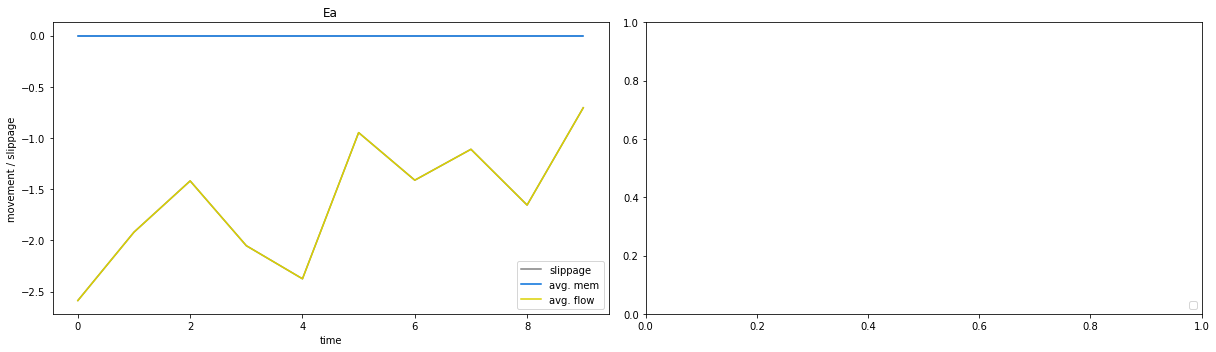

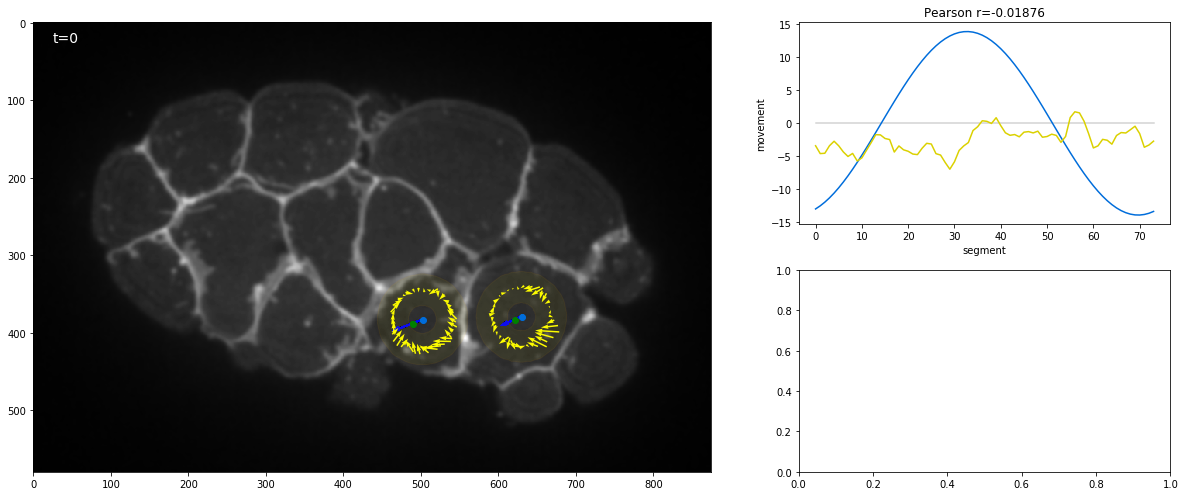

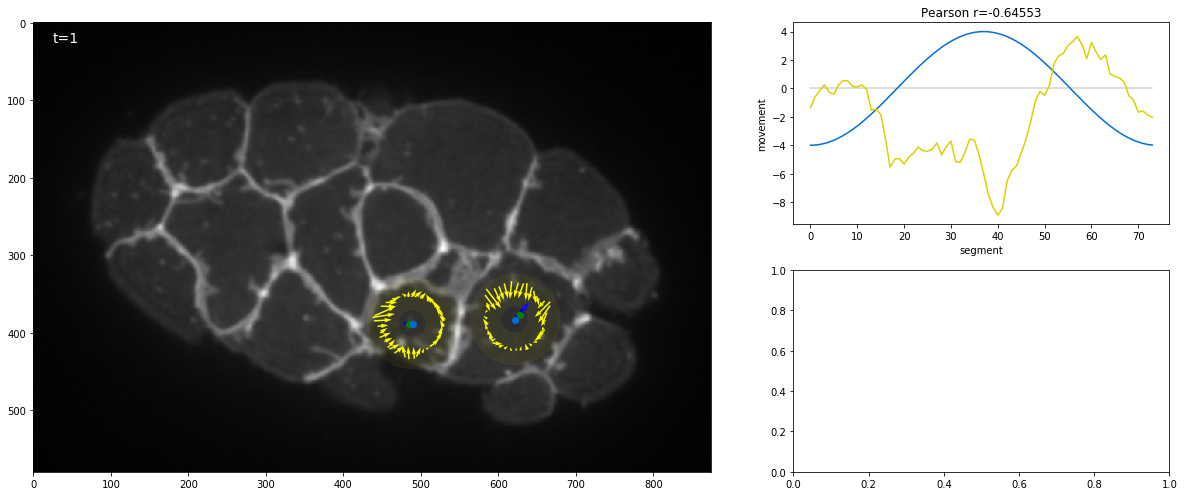

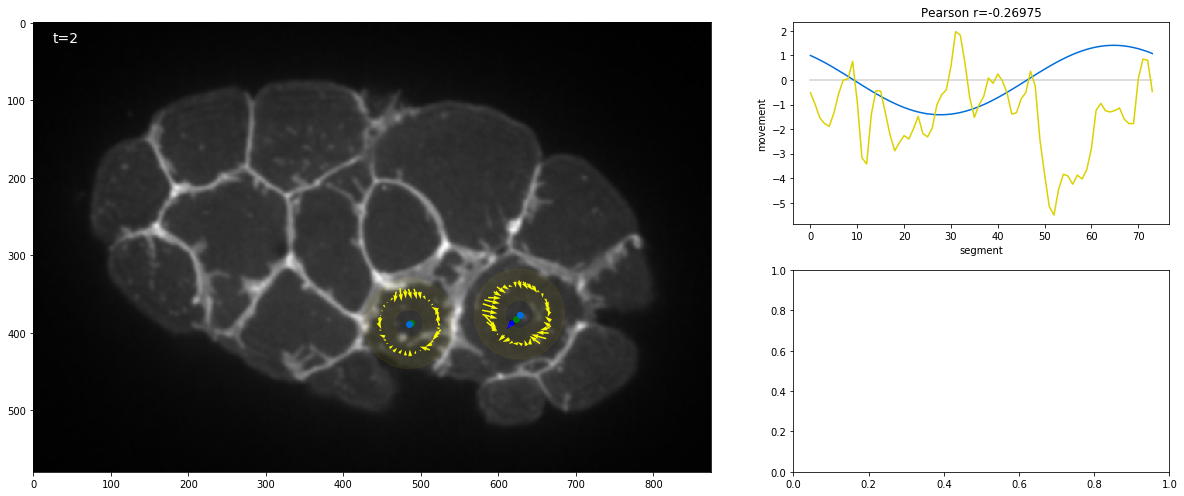

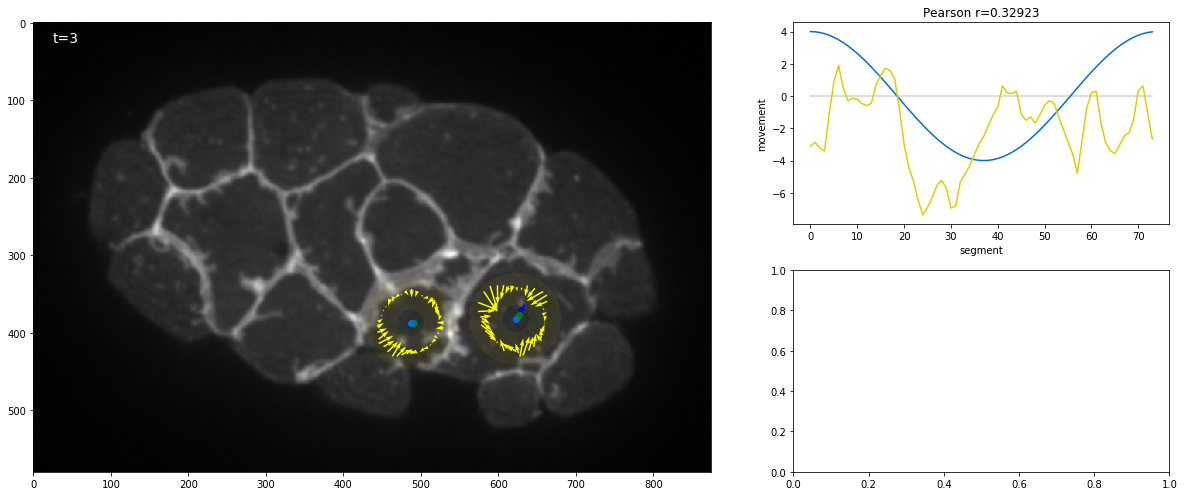

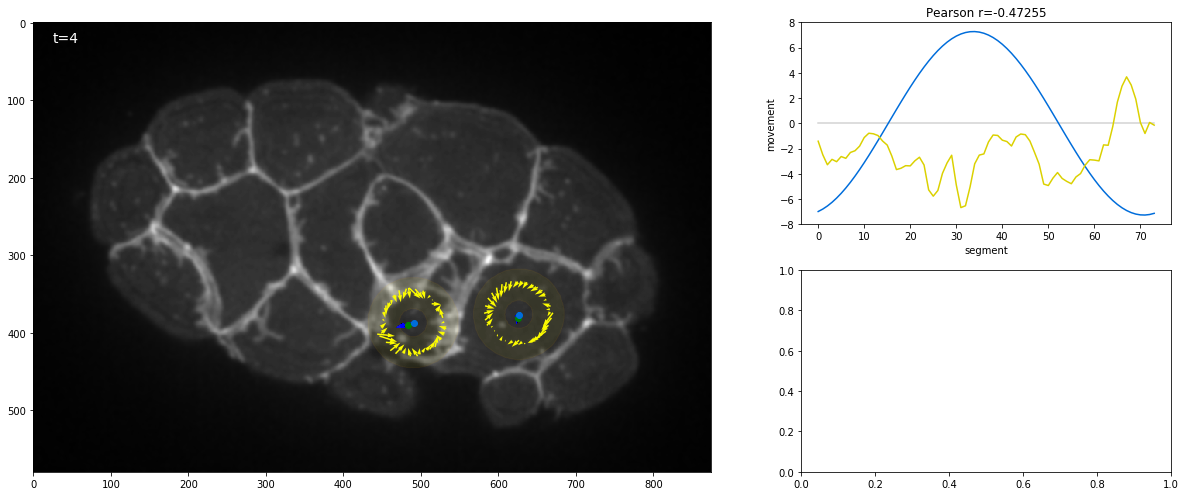

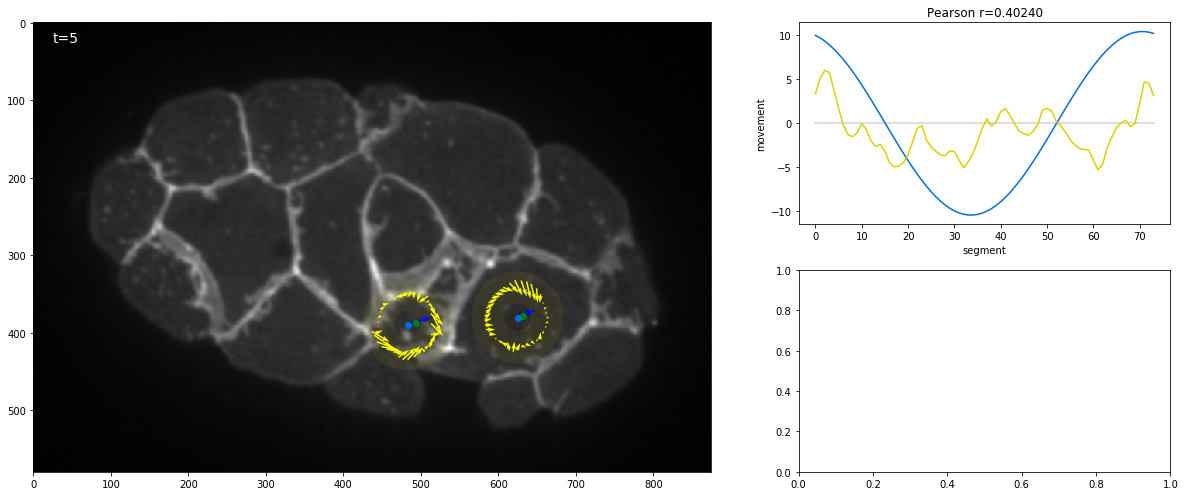

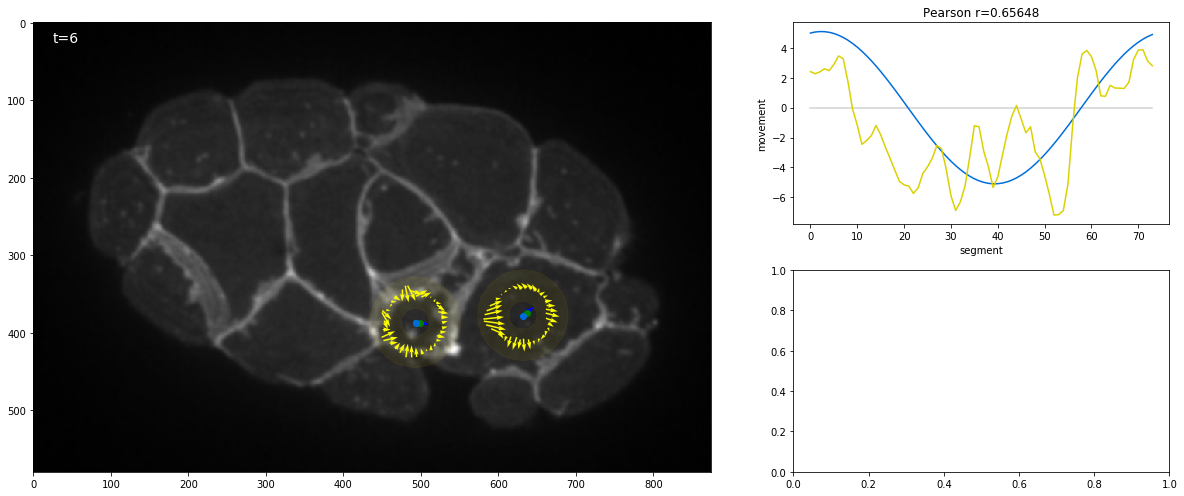

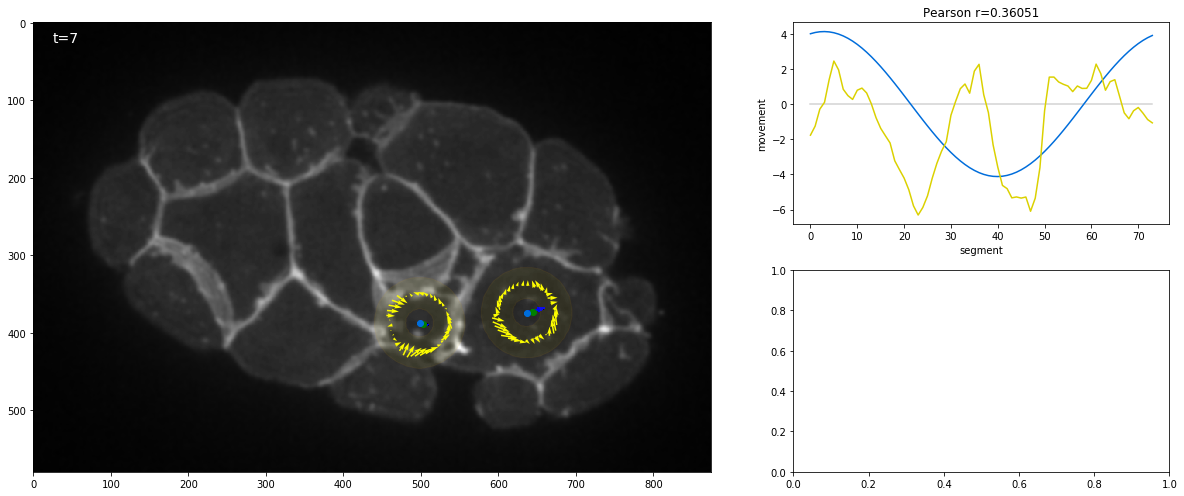

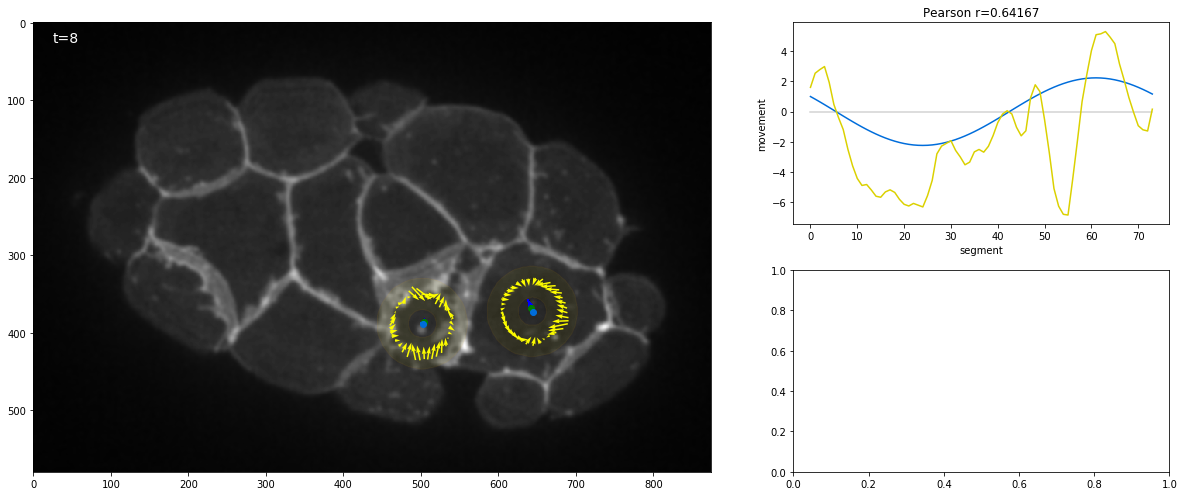

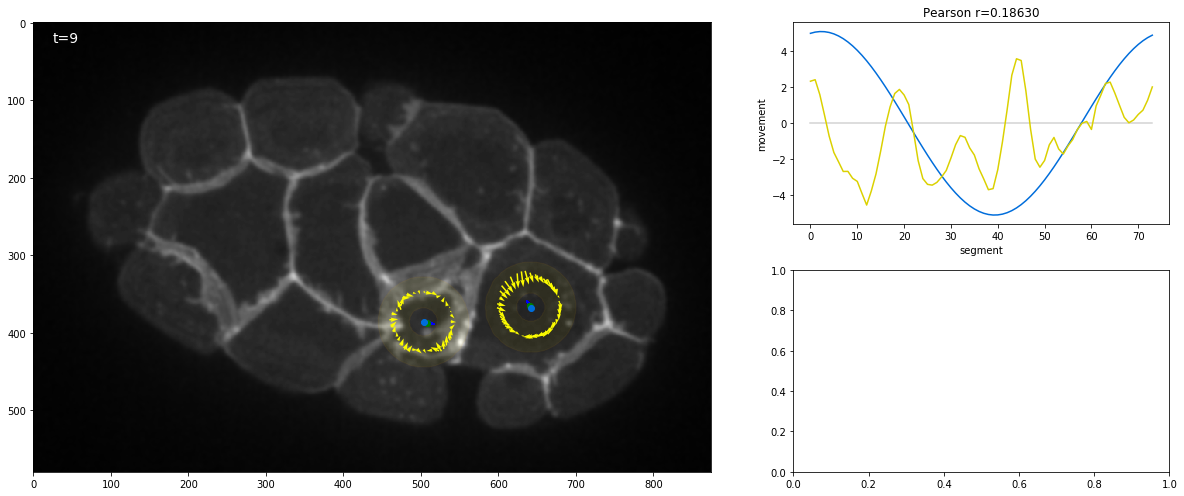

In [35]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / slippage')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
#ax.plot(correlation_per_frame_per_object[0], '*', color='gray', label='pearson r')
ax.plot(slippage_per_frame_per_object[0], color='gray', label='slippage')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)
# ax.set_title(data.object_names[1])
# ax.set_xlabel('time')
# ax.set_ylabel('movement / slippage')
# ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
# # ax.plot(correlation_per_frame_per_object[1], color='gray', label='pearson r')
# ax.plot(slippage_per_frame_per_object[1], color='gray', label='slippage')
# ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
# ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()
# fig.savefig('/Users/prakash/Desktop/BobSegDataAndResults/FlowResults/20180501_CoupledMembrane.png',dpi = 300)

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = False

for t in range(0,len(segchannel)-1,1):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(query_centroids[obj][t+1][1],query_centroids[obj][t+1][0], 'o', color='green')
        ax.plot(query_centroids[obj][t][1],query_centroids[obj][t][0], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

        # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x[offset::stepsize], 
                  flow_base_y[offset::stepsize], 
                  flow_vec_x[offset::stepsize], 
                  flow_vec_y[offset::stepsize], 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/2., color='yellow')
        
    # LINEPLOT
    # ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))

#     ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
#     ax3.set_xlabel('segment')
#     ax3.set_ylabel('movement')
#     ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
#     ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
#     ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))

    fig.tight_layout()

In [27]:
c,p = pearsonr(avg_membrane_contraction_per_frame_per_object[0], avg_center_flow_per_frame_per_object[0])
print(c)

-0.0837485875703443


In [28]:
c,p = pearsonr(avg_membrane_contraction_per_frame_per_object[1], avg_center_flow_per_frame_per_object[1])
print(c)

0.22097959308025727


In [29]:
for i in range(len(avg_membrane_contraction_per_frame_per_object[1])):

    print(avg_membrane_contraction_per_frame_per_object[1][i])

-0.4586800650998908
0.21573476573758832
0.2905248054785022
-0.16181344418882418
-0.310675432133251
-1.2669456399174983
-1.9680644094586173
-1.5211747893853251
-0.9969692690815121
-0.6447720075288577


In [30]:
for i in range(len(avg_center_flow_per_frame_per_object[0])):
    print(avg_membrane_contraction_per_frame_per_object[0][i])

-0.12909247700323015
-0.6134078144367687
-1.3195526833304068
-1.104104645914198
-0.08048713306018633
-0.7353439532532628
-0.23647210339933789
-1.307600962575813
0.07726759908139612
0.5454215271023162
